# BP+OSD: A decoder for quantum LDPC codes 
A Python library implementing belief propagation with ordered statistics post-processing for decoding sparse quantum LDPC codes as described in [arXiv:2005.07016](https://arxiv.org/abs/2005.07016). Note, this library has recently been completly rewritten using Python and Cython. The bulk of the code now resides in the [LDPC](https://github.com/quantumgizmos/ldpc) repository. The original C++ version can be found in the `cpp_version` branch of this repository.

## Installation from PyPi (recommended method)

Installation from [PyPi](https://pypi.org/project/bposd/) requires Python>=3.6.
To install via pip, run:

```
pip install -U bposd
```

## Documentation
This package buids upon the [LDPC](https://github.com/quantumgizmos/ldpc) python package. The documentation for LDPC can be found [here](https://roffe.eu/software/ldpc/index.html).

## Attribution
If you use this software in your research, please cite the following research paper:

```
@article{roffe_decoding_2020,
   title={Decoding across the quantum low-density parity-check code landscape},
   volume={2},
   ISSN={2643-1564},
   url={http://dx.doi.org/10.1103/PhysRevResearch.2.043423},
   DOI={10.1103/physrevresearch.2.043423},
   number={4},
   journal={Physical Review Research},
   publisher={American Physical Society (APS)},
   author={Roffe, Joschka and White, David R. and Burton, Simon and Campbell, Earl},
   year={2020},
   month={Dec}
}
```

Please also cite the LDPC software package:

```
@software{Roffe_LDPC_Python_tools_2022,
author = {Roffe, Joschka},
title = {{LDPC: Python tools for low density parity check codes}},
url = {https://pypi.org/project/ldpc/},
year = {2022}
}
```

# Basic usage

## Constructing CSS codes

The `bposd.css.css_code` class can be used to create a CSS code from two classical codes. As an example, we can create a [[7,4,3]] Steane code from the classical Hamming code

In [1]:
from ldpc.codes import hamming_code
from bposd.css import css_code
h=hamming_code(3) #Hamming code parity check matrix
steane_code=css_code(hx=h,hz=h) #create Steane code where both hx and hz are Hamming codes
print("Hx")
print(steane_code.hx)
print("Hz")
print(steane_code.hz)

Hx
[[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]
Hz
[[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]


The `bposd.css.css_code` class automatically computes the logical operators of the code.

In [2]:
print("Lx Logical")
print(steane_code.lx)
print("Lz Logical")
print(steane_code.lz)

Lx Logical
[[1 1 1 0 0 0 0]]
Lz Logical
[[1 1 1 0 0 0 0]]


Not all combinations of the `hx` and `hz` matrices will produce a valid CSS code. Use the `bposd.css.css_code.test` function to check whether the code is valid. For example, we can easily check that the Steane code passes all the CSS code tests:

In [3]:
steane_code.test()

<Unnamed CSS code>, (3,4)-[[7,1,nan]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (3,4)-[[7,1,nan]]


True

As an example of a code that isn't valid, consider the case when `hx` and `hz` are repetition codes:

In [4]:
from ldpc.codes import rep_code

hx=hz=rep_code(7)
qcode=css_code(hx,hz)
qcode.test()

<Unnamed CSS code>, (2,2)-[[7,-5,nan]]
 -Block dimensions incorrect
 -PCMs commute hz@hx.T==0: Fail
 -PCMs commute hx@hz.T==0: Fail
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anitcommute: Fail


False

## Hypergraph product codes

The hypergraph product can be used to construct a valid CSS code from any pair of classical seed codes. To use the the hypergraph product, call the `bposd.hgp.hgp` function. Below is an example of how the distance-3 surface code can be constructed by taking the hypergraph product of two distance-3 repetition codes.

In [5]:
from ldpc.codes import rep_code
from bposd.hgp import hgp
h=rep_code(3)
surface_code=hgp(h1=h,h2=h,compute_distance=True) #nb. set compute_distance=False for larger codes
surface_code.test()

<Unnamed CSS code>, (2,4)-[[13,1,3]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (2,4)-[[13,1,3]]


True

## BP+OSD Decoding

BP+OSD decoding is useful for codes that do not perform well under standard-BP. To use the BP+OSD decoder, we first call the `bposd.bposd_decoder` class:

In [6]:
import numpy as np
from ldpc import bposd_decoder

bpd=bposd_decoder(
    surface_code.hz,#the parity check matrix
    #hz1,
    error_rate=0.05,
    xyz_error_bias= [0, 0, 1],
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=surface_code.N, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=7 #the osd search depth
    )

In [7]:
import numpy as np
from ldpc import bposd_decoder

bpd=bposd_decoder(
    steane_code.hz,#the parity check matrix
    #hz1,
    error_rate=0.05,
    xyz_error_bias= [0, 0, 1],
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=steane_code.N, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=4 #the osd search depth
    )


In [8]:
from ldpc.codes import hamming_code
from bposd.css import css_code
h=hamming_code(3) #Hamming code parity check matrix
steane_code=css_code(hx=h,hz=h) #create Steane code where both hx and hz are Hamming codes
print("Hx")
print(steane_code.hx)
print("Hz")
print(steane_code.hz)
hz_s1 = steane_code.hz
hz_s1[-2,:]=(hz_s1[-1,:]+hz_s1[-2,:])%2
hz_s1[-1,:] = np.zeros(len(hz_s1[-1,:]))
print(hz_s1)

Hx
[[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]
Hz
[[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]
[[0 0 0 1 1 1 1]
 [1 1 0 0 1 1 0]
 [0 0 0 0 0 0 0]]


In [9]:
import numpy as np
from ldpc import bposd_decoder

bpd=bposd_decoder(
    hz_s1,#the parity check matrix
    #hz1,
    error_rate=0.05,
    xyz_error_bias= [0, 0, 1],
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=steane_code.N, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=4 #the osd search depth
    )


In [10]:
h=hamming_code(3) #Hamming code parity check matrix
steane_code=css_code(hx=h,hz=h)
print(steane_code.lz)
lz1 = steane_code.lz

lz1[0][1] = 0
lz1[0][2] = 0
lz1[0][5] = 1
lz1[0][6] = 1
print(lz1)

[[1 1 1 0 0 0 0]]
[[1 0 0 0 0 1 1]]


In [11]:
# sample the errors:

# for one-layer 7 qubit:
# combine the qubit loss
# 2/3 * p

# X and Z both

# for multi-layer 7 qubit

# for multi-layer 48 qubit

error=np.zeros(steane_code.N).astype(int)
print(error)
error[[0]]=1
print(error)
syndrome=hz_s1@error %2
#syndrome=steane_code.hz@error % 2
print(syndrome)
bpd.decode(syndrome)

print("Error")
print(error)
print("BP+OSD Decoding")
print(bpd.osdw_decoding)
#Decoding is successful if the residual error commutes with the logical operators
residual_error=(bpd.osdw_decoding+error) %2
a=(lz1@residual_error%2).any()
print(lz1)
print((lz1@residual_error%2))
print(a)
if a: a="Yes"
else: a="No"
print(f"Logical Error: {a}\n")

[0 0 0 0 0 0 0]
[1 0 0 0 0 0 0]
[0 1 0]
Error
[1 0 0 0 0 0 0]
BP+OSD Decoding
[1 0 0 0 0 0 0]
[[1 0 0 0 0 1 1]]
[0]
False
Logical Error: No



# BP+OSD decoding with a for loop

In [12]:
# first for loop:
# under one qubit loss case:
# 1000 samples for pauli error?; 10000 samples for pauli error?
# use Sx_mat and logicals (for the time being) to represent the remaining stabilizers/logical

# define the "BP+OSD" decoder using the remaining Sx_mat
import numpy as np
from ldpc import bposd_decoder

bpd=bposd_decoder(
    Sx_mat,#the parity check matrix
    error_rate=0.05,
    xyz_error_bias= [1, 0, 0],
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=steane_code.N, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=4 #the osd search depth
    )

# sample the Pauli error:
error=np.zeros(steane_code.N).astype(int)
error[[0]]=1
syndrome=Sx_mat @error %2
#syndrome=steane_code.hz@error % 2
bpd.decode(syndrome)
#Decoding is successful if the residual error commutes with the logical operators
residual_error=(bpd.osdw_decoding+error) %2
a=(lz1@residual_error%2).any()
if a: a="Yes"
else: a="No"
print(f"Logical Error: {a}\n")

NameError: name 'Sx_mat' is not defined

In [13]:
import numpy as np
Nrep = 1000
# pauli error p we want to test
p = 0.005
for i_rep in range(Nrep):
    error=np.zeros(steane_code.N).astype(int)
    loss_inds = np.random.permutation(np.argwhere(np.random.rand(steane_code.N)<p)[:,0])
    error[loss_inds] = 1

In [14]:
from ldpc.codes import hamming_code
from bposd.css import css_code
h=hamming_code(3) #Hamming code parity check matrix
steane_code=css_code(hx=h,hz=h) #create Steane code where both hx and hz are Hamming codes
hz_s1 = steane_code.hz
hz_s1[-2,:]=(hz_s1[-1,:]+hz_s1[-2,:])%2
hz_s1[-1,:] = np.zeros(len(hz_s1[-1,:]))
h=hamming_code(3) #Hamming code parity check matrix
steane_code=css_code(hx=h,hz=h)
lz1 = steane_code.lz
lz1[0][1] = 0
lz1[0][2] = 0
lz1[0][5] = 1
lz1[0][6] = 1
Sx_mat = hz_s1
logicals = lz1
print(Sx_mat)
print(logicals)

[[0 0 0 1 1 1 1]
 [1 1 0 0 1 1 0]
 [0 0 0 0 0 0 0]]
[[1 0 0 0 0 1 1]]


In [15]:
# then do the correction:
import numpy as np
import time

# list the constant parameters: 
# 1. the number of samples for pauli errors (for each photon loss case): N_ps
N_ps = 100
# 2. error rate of pauli errors:
p_pauli = 0.005
# 3. max number of iteratios for BP, set to be the number of physical qubits in the code
N_iter = steane_code.N
# 4. N_q: just the number of physical qubits in the code 
N_q = steane_code.N

# add the loop outside that: which is the photon loss different cases

# Ex1: give a specific Sx and logicals, feed into the Pauli error sample loop; test 
# 1.result stats 2. running time
Sx_mat = hz_s1
logicals = lz1
N_pauli_succ = 0

tic = time.time()

bpd=bposd_decoder(
    Sx_mat,#the parity check matrix
    error_rate = 2/3*p_pauli,
    xyz_error_bias= [1, 0, 0],
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter = N_iter, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=4 #the osd search depth
    )

for i_rep in range(N_ps):
    error=np.zeros(N_q).astype(int)
    loss_inds = np.random.permutation(np.argwhere(np.random.rand(steane_code.N)<p_pauli)[:,0])
    error[loss_inds] = 1
    
    syndrome=Sx_mat @error %2
    #syndrome=steane_code.hz@error % 2
    bpd.decode(syndrome)
    #Decoding is successful if the residual error commutes with the logical operators
    residual_error=(bpd.osdw_decoding+error) %2
    # change "lz1" to logicals?
    a = (logicals@residual_error%2).any()
    if not a: 
        N_pauli_succ += 1

p_pauli_succ = N_pauli_succ / N_ps
    #if a: a="Yes"
    #else: a="No"
    #print(f"Logical Error: {a}\n")
    # add counting variable
print(p_pauli_succ)

toc = time.time()
print(toc - tic)

0.97
0.008116006851196289


In [16]:
#one-layer steane code
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time
from EffP import *
from QLPDCgen import *
from PLmatrix_CSS import *

def succ_prob_css_calc_new(B_orig, logicals_in, s_nodes, loss_inds):
    ######################################################
    ## inputs:
    ## B_orig [type: networkx]: stabilizer graph, two kinds of nodes: qubit 1...N and stabilizer s1...s_{Ns}
    ## logicals_in [type: list of numpy arrays]: logical operators in every row, columns act on qubits
    ## s_nodes [type: list]: list of stabilizer nodes s1...s_{Ns}
    ## loss_inds [type: numpy array]: index of erased qubits
    #####################
    ## output:
    ## succ_fail [type: binary value]: 0 (failure), 1(success)
    ######################################################
    N = np.size(logicals_in,1)
    B = B_orig.copy()
    logicals = list(np.copy(logicals_in))
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set) # number of stabilizer generators
    q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
    node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

    for i_q, q in enumerate(loss_inds):
        ## correct logical operators
        logicals = correct_logical(q,logicals, Sx_mat)
        ## update stabilizer group
        ## first: update graph
        if q in B:
            B, s_nodes_set = modify_graph(q,B,s_nodes_set)
        ## second: update stabilizer group matrix
            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                # break
    num_qs = 0
    if len(logicals)>=1:
        for i_l in range(len(logicals)):
            if np.sum(logicals[i_l][loss_inds])==0:
                num_qs += 1 
            # print(logicals)
    return num_qs, Sx_mat, logicals

# then do the correction:
import numpy as np
import time

# list the constant parameters: 
# 1. the number of samples for pauli errors (for each photon loss case): N_ps
N_ps = 100
# 2. error rate of pauli errors:
p_pauli = 0.005
# 3. max number of iteratios for BP, set to be the number of physical qubits in the code
N_iter = steane_code.N
# 4. N_q: just the number of physical qubits in the code 
N_q = steane_code.N

# add the loop outside that: which is the photon loss different cases

Sx_mat = hz_s1
logicals = lz1
N_pauli_succ = 0

tic = time.time()

bpd=bposd_decoder(
    Sx_mat,#the parity check matrix
    error_rate = 2/3*p_pauli,
    xyz_error_bias= [1, 0, 0],
    channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter = N_iter, #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=4 #the osd search depth
    )

for i_rep in range(N_ps):
    error=np.zeros(N_q).astype(int)
    loss_inds = np.random.permutation(np.argwhere(np.random.rand(steane_code.N)<p_pauli)[:,0])
    error[loss_inds] = 1
    
    syndrome=Sx_mat @error %2
    #syndrome=steane_code.hz@error % 2
    bpd.decode(syndrome)
    #Decoding is successful if the residual error commutes with the logical operators
    residual_error=(bpd.osdw_decoding+error) %2
    # change "lz1" to logicals?
    a = (logicals@residual_error%2).any()
    if not a: 
        N_pauli_succ += 1

p_pauli_succ = N_pauli_succ / N_ps
    #if a: a="Yes"
    #else: a="No"
    #print(f"Logical Error: {a}\n")
    # add counting variable
print(p_pauli_succ)

toc = time.time()
print(toc - tic)

0.96
0.001528024673461914


In [ ]:
#one-layer steane code
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time
from EffP import *
from QLPDCgen import *
from PLmatrix_CSS import *

def succ_prob_css_calc_new(B_orig, logicals_in, s_nodes, loss_inds):
    ######################################################
    ## inputs:
    ## B_orig [type: networkx]: stabilizer graph, two kinds of nodes: qubit 1...N and stabilizer s1...s_{Ns}
    ## logicals_in [type: list of numpy arrays]: logical operators in every row, columns act on qubits
    ## s_nodes [type: list]: list of stabilizer nodes s1...s_{Ns}
    ## loss_inds [type: numpy array]: index of erased qubits
    #####################
    ## output:
    ## succ_fail [type: binary value]: 0 (failure), 1(success)
    ######################################################
    N = np.size(logicals_in,1)
    B = B_orig.copy()
    logicals = list(np.copy(logicals_in))
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set) # number of stabilizer generators
    #print(Ns_remain)
    q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
    node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

    for i_q, q in enumerate(loss_inds):
        ## correct logical operators
        logicals = correct_logical(q,logicals, Sx_mat)
        ## update stabilizer group
        ## first: update graph
        if q in B:
            B, s_nodes_set = modify_graph(q,B,s_nodes_set)
        ## second: update stabilizer group matrix
            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                #Sx_mat = []
                Sx_mat = np.zeros((Ns_remain,N))
                # break
    num_qs = 0
    if len(logicals)>=1:
        #print(len(logicals))
        for i_l in range(len(logicals)):
            if np.sum(logicals[i_l][loss_inds])==0:
                num_qs += 1 
            # print(logicals)
    return num_qs, Sx_mat, logicals

# then do the correction:
import numpy as np
import time

# list the constant parameters: 
# 1. the number of samples for pauli errors (for each photon loss case): N_ps
N_ps = 100
# 2. error rate of pauli errors:
p_pauli = 0.001
# 3. max number of iteratios for BP, set to be the number of physical qubits in the code
#N_iter = steane_code.N
# 4. N_q: just the number of physical qubits in the code 
#N_q = steane_code.N

# add the loop outside that: which is the photon loss different cases

bdy = True ## boundary condition, true (obc), false(pbc)
repeat = 100
Nrep = 10000 # number of iterations
Nl_list = np.arange(1,2,2)
#print(Nl_list)
Nl_list = [5]
#print(Nl_list)
p_list = [0.05,0.1,0.15,0.2,0.25,0.3]

# in layer stabilizer group
Sx_mat = np.array([[1,1,1,1,0,0,0],\
              [1,1,0,0,1,1,0],\
              [1,0,1,0,1,0,1]])
Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer

for i_L, Nl in enumerate(Nl_list):
    #print("L= %d" % (Nl))

    N = Nl*(Nq_l+Ns_l)+Ns_l # number of data qubits
    #print("N:",N)
    Ns = Nl*Ns_l # number of stabilizers
    s_nodes = ["s%d" % s for s in np.arange(Ns)]

    B_orig = foliated_graph(Sx_mat,s_nodes, Nl, bdy, "even")
    logical = np.zeros((1,N))
    for i_l in range(Nl):
        logical[0,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = np.ones(Nq_l)

    def runner(i_rep):
        tic = time.time()

        succ_prob_7_ml = np.zeros(len(p_list))
        for i_p, p_r in enumerate(p_list):
            p_stab = 1-(1-p_r)**0.5
            N_ls = 0 #N_loss_success
            for i_r in range(Nrep):
                loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p_stab)[:,0])
                succ_prob_7_num, Sx_mat, logicals = succ_prob_css_calc_new(B_orig, logical, s_nodes, loss_inds)
                if succ_prob_7_num != 0:
                    N_ls += 1
                    bpd=bposd_decoder(
                        Sx_mat,#the parity check matrix
                        error_rate = 2/3*p_pauli,
                        xyz_error_bias= [1, 0, 0],
                        channel_probs=[None], #assign error_rate to each qubit. This will override "error_rate" input variable
                        max_iter = N_iter, #the maximum number of iterations for BP)
                        bp_method="ms",
                        ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
                        osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
                        osd_order=4 #the osd search depth
                        )
                    
                    error=np.zeros(N).astype(int)
                    loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p_pauli)[:,0])
                    error[loss_inds] = 1
                    syndrome=Sx_mat @error %2
                    bpd.decode(syndrome)
                    #Decoding is successful if the residual error commutes with the logical operators
                    residual_error=(bpd.osdw_decoding+error) %2
                    a = (logicals@residual_error%2).any()
                    if not a: 
                        succ_prob_7_ml[i_p] += 1
            succ_prob_7_ml[i_p] /= N_ls
        print(succ_prob_7_ml)
        toc = time.time()
        print("finished L = %d, r=%d in %.1f secs" % (Nl,i_rep,toc-tic))

        if bdy:
            fname = "pauli/7q/" + "even_Nl_%d_i_%d.npz" % (Nl,i_rep)
        else:
            assert 0

        np.savez(fname, succ_prob=succ_prob_7_ml, p_list=p_list, Nrep=Nrep)

        return 0
    #results = Parallel(n_jobs=num_cores)(delayed(runner)(i_rep) for i_rep in range(repeat))
    results = runner(0)

In [ ]:
#multi-layer steane code


Text(0.5, 1.0, 'logical error loss decoding success cases; even layer, Nl=5, e_d=0.001 ')

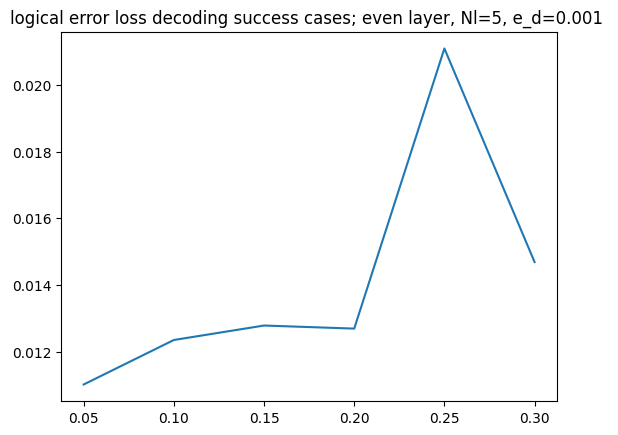

In [50]:
p_list = [0.05,0.1,0.15,0.2,0.25,0.3]
#p_nPauli = [0.9948, 0.9787, 0.9423, 0.8779, 0.7922, 0.6821]
#p_Pauli = [0.98288, 0.96765, 0.92494, 0.87461, 0.75745, 0.6554 ]
P_logical_succ = [0.98898899, 0.98765432, 0.98722045, 0.98731257, 0.97890819, 0.98531571]
#plt.plot(p_list, 1-np.array(p_nPauli))
#plt.plot(p_list, 0.001/(1-np.array(p_Pauli)))
plt.plot(p_list, 1-np.array(P_logical_succ))
plt.title('logical error loss decoding success cases; even layer, Nl=5, e_d=0.001 ')

Text(0.5, 1.0, 'Nl=10, even layer')

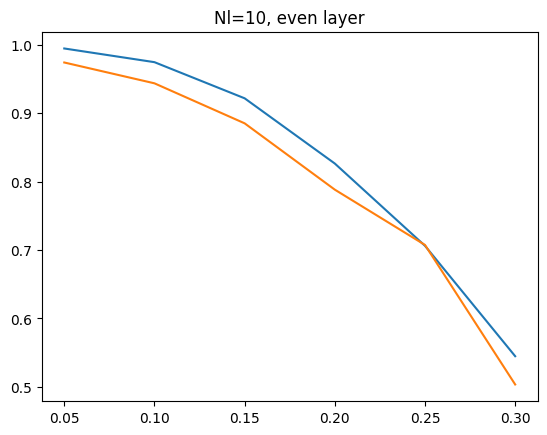

In [40]:
p_list = [0.05,0.1,0.15,0.2,0.25,0.3]
p_nPauli = [0.9944, 0.9744, 0.9216, 0.8263, 0.7061, 0.5448]
p_Pauli = [0.97393, 0.9435,  0.88504, 0.78814, 0.70735, 0.50349]
plt.plot(p_list, p_nPauli)
plt.plot(p_list, p_Pauli)
plt.title('Nl=10, even layer')

In [ ]:
#one-layer 48q code


In [ ]:
#multi-layer 48q code
